# Natural Language Processing with Disaster Tweets
## Kaggle Competition Mini Project
### Introduction to Deep Learning

In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/alec/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/alec/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [37]:
# Import required libraries for model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D)
import re

import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import itertools

## Step 1: Brief Description of the Problem and Data

This project focuses on classifying tweets as either real disaster-related or not.
The objective is to train a model that can differentiate between the two even if langauge is similar between the two. 
 
Dataset Description:
- Source: Kaggle Competition "Natural Language Processing with Disaster Tweets"
- Task: Binary Classification (Real Disaster = 1, Not Real Disaster = 0)
- Features: text, keyword, location
- Size: Training and test sets with multiple columns


In [38]:
# Load the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Display basic information about the dataset
print("Dataset Overview:")
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print("\nTraining set columns:", train_df.columns.tolist())
 
# Display sample tweets
print("\nSample Tweets:")
print(train_df[['text', 'target']].head())

Dataset Overview:
Training set shape: (7613, 5)
Test set shape: (3263, 4)

Training set columns: ['id', 'keyword', 'location', 'text', 'target']

Sample Tweets:
                                                text  target
0  Our Deeds are the Reason of this #earthquake M...       1
1             Forest fire near La Ronge Sask. Canada       1
2  All residents asked to 'shelter in place' are ...       1
3  13,000 people receive #wildfires evacuation or...       1
4  Just got sent this photo from Ruby #Alaska as ...       1


## Step 2: Exploratory Data Analysis (EDA)

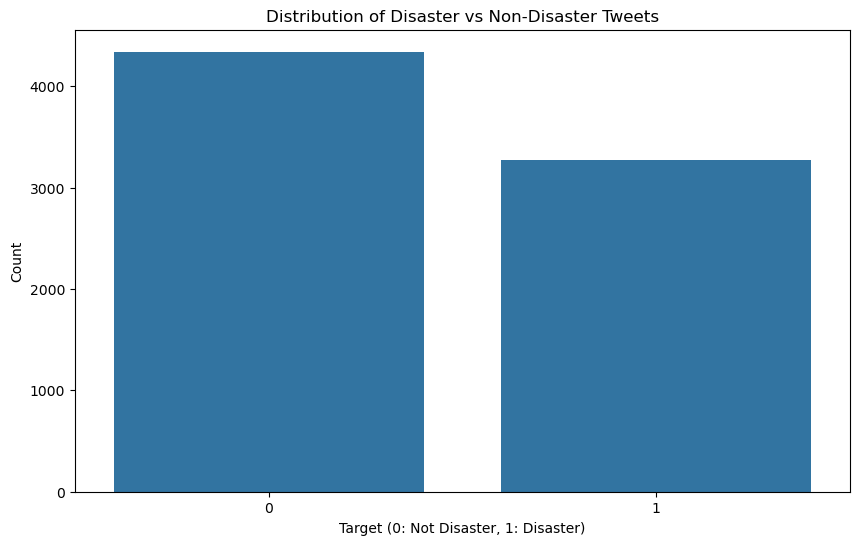


Missing Values Analysis:
            Column  Missing Values  Percentage
id              id               0    0.000000
keyword    keyword              61    0.801261
location  location            2533   33.272035
text          text               0    0.000000
target      target               0    0.000000


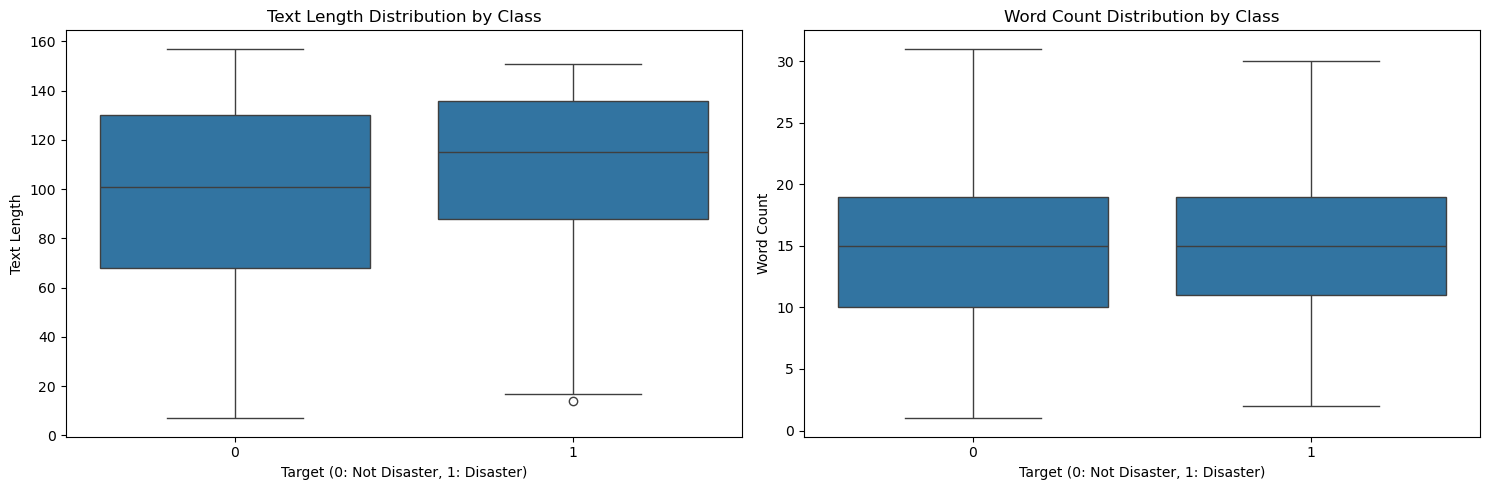

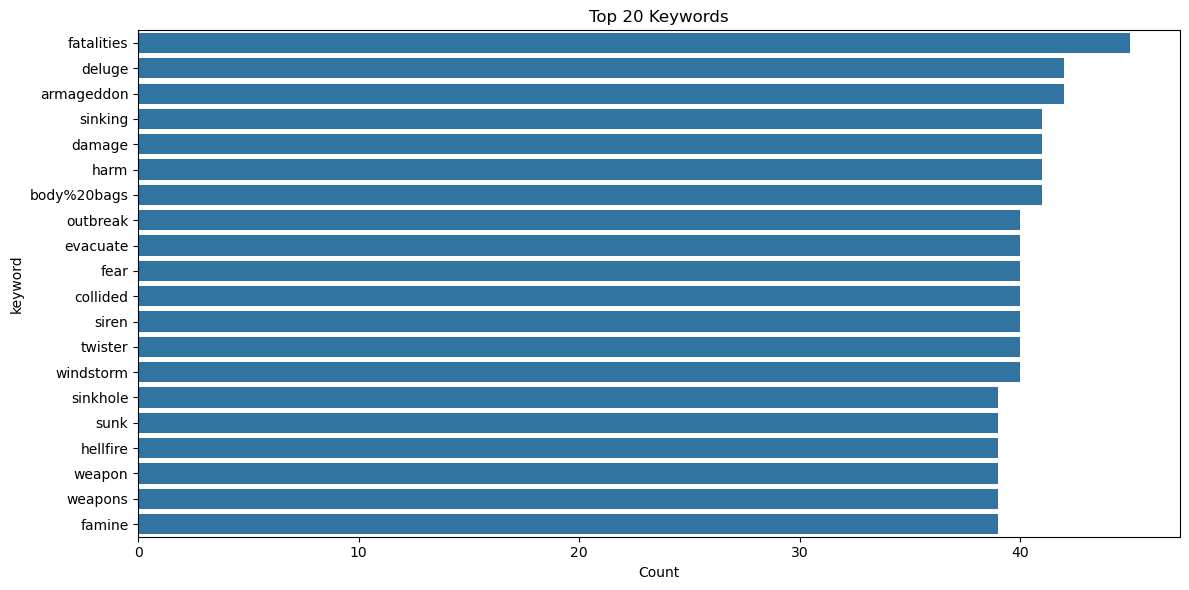

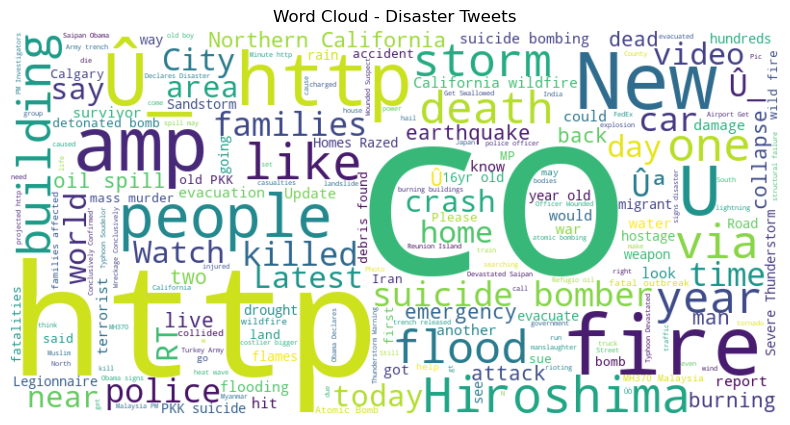

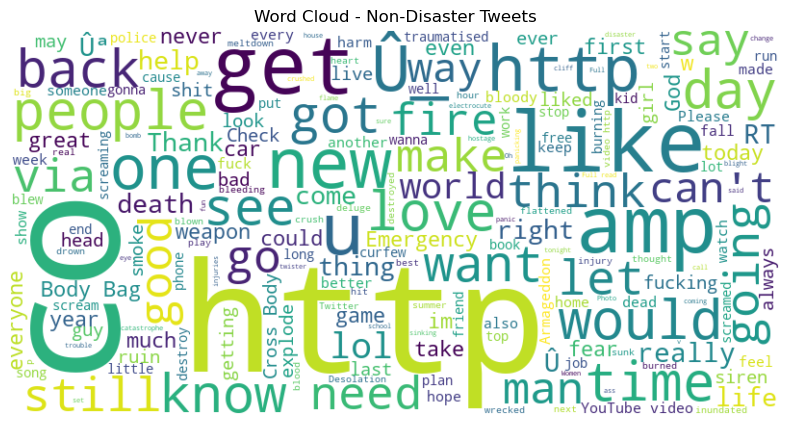


Most common words in disaster tweets:
-           389
fire        151
via         117
...         106
&amp;       105
suicide     103
disaster     97
police       94
people       93
killed       92
Name: count, dtype: int64

Most common words in non-disaster tweets:
-        374
like     250
&amp;    190
??       183
new      163
get      161
one      116
body     106
via       97
would     94
Name: count, dtype: int64


In [39]:
# 1. Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='target')
plt.title('Distribution of Disaster vs Non-Disaster Tweets')
plt.xlabel('Target (0: Not Disaster, 1: Disaster)')
plt.ylabel('Count')
plt.show()
 
# 2. Missing Values Analysis
missing_values = pd.DataFrame({
    'Column': train_df.columns,
    'Missing Values': train_df.isnull().sum(),
    'Percentage': (train_df.isnull().sum() / len(train_df)) * 100
})
print("\nMissing Values Analysis:")
print(missing_values)
 
# 3. Text Length Analysis
train_df['text_length'] = train_df['text'].str.len()
train_df['word_count'] = train_df['text'].str.split().str.len()
 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
 
# Text length distribution by class
sns.boxplot(data=train_df, x='target', y='text_length', ax=ax1)
ax1.set_title('Text Length Distribution by Class')
ax1.set_xlabel('Target (0: Not Disaster, 1: Disaster)')
ax1.set_ylabel('Text Length')
 
# Word count distribution by class
sns.boxplot(data=train_df, x='target', y='word_count', ax=ax2)
ax2.set_title('Word Count Distribution by Class')
ax2.set_xlabel('Target (0: Not Disaster, 1: Disaster)')
ax2.set_ylabel('Word Count')
plt.tight_layout()
plt.show()
 
# 4. Keyword Analysis
plt.figure(figsize=(12, 6))
top_keywords = train_df['keyword'].value_counts().head(20)
sns.barplot(x=top_keywords.values, y=top_keywords.index)
plt.title('Top 20 Keywords')
plt.xlabel('Count')
plt.tight_layout()
plt.show()
 
# 5. Word Clouds
def create_wordcloud(text_series, title):
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         stopwords=set(stopwords.words('english'))).generate(' '.join(text_series))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()
 
# Word cloud for disaster tweets
create_wordcloud(train_df[train_df['target']==1]['text'], 'Word Cloud - Disaster Tweets')
 
# Word cloud for non-disaster tweets
create_wordcloud(train_df[train_df['target']==0]['text'], 'Word Cloud - Non-Disaster Tweets')
 
# 6. Basic Text Analysis
def get_common_words(text_series, n=10):
    all_words = ' '.join(text_series).lower().split()
    word_freq = pd.Series(all_words).value_counts()
    return word_freq[~word_freq.index.isin(stopwords.words('english'))].head(n)
 
print("\nMost common words in disaster tweets:")
print(get_common_words(train_df[train_df['target']==1]['text']))
 
print("\nMost common words in non-disaster tweets:")
print(get_common_words(train_df[train_df['target']==0]['text']))

#### Summary of EDA findings

From my EDA, I can see that there are more non-disaster tweets in the training set than there are disaster tweets. There are also missing values in some entries for the keywords and locations of the tweets, we will remove those from our model moving forward. 

In terms of word/text counts, there is a marginal difference between the two classes, assuming this data set is from when Twitter (X) only allowed 140 characters per tweet this makes sense. I also printed out the top 20 words used throughout the set to get a better idea of the data as well and a few other visuals to practice and learn more about the data set.
 
Based on these findings, my preprocessing strategy will include:
1. Handling missing values in keyword and location columns
2. Text cleaning and normalization
3. Feature engineering based on text length and word counts
4. Consideration of keyword importance in classification


## Step 3: Model Architecture and Text Processing 

Model Architecture Strategy:
1. Text Preprocessing Pipeline
2. Word Embedding Layer
3. Bidirectional LSTM layers
4. Dense layers with dropout for regularization

In [25]:
class TweetPreprocessor:
    def __init__(self, max_words=10000, max_len=100):
        self.max_words = max_words
        self.max_len = max_len
        self.tokenizer = Tokenizer(num_words=max_words)
       
    def clean_text(self, text):
        """Clean and normalize text"""
        # Convert to lowercase
        text = text.lower()
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Replace user mentions with generic token
        text = re.sub(r'@\w+', '@user', text)
        # Replace hashtags with just the word
        text = re.sub(r'#(\w+)', r'\1', text)
        # Remove special characters and numbers
        text = re.sub(r'[^\w\s]', '', text)
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text
   
    def prepare_text_data(self, texts, fit=False):
        """Prepare text data for model"""
        # Clean texts
        cleaned_texts = [self.clean_text(text) for text in texts]
       
        # Tokenize
        if fit:
            self.tokenizer.fit_on_texts(cleaned_texts)
           
        sequences = self.tokenizer.texts_to_sequences(cleaned_texts)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_len, padding='post')
       
        return padded_sequences
 
class DisasterTweetClassifier:
    def __init__(self, max_words, max_len, embedding_dim=100):
        self.max_words = max_words
        self.max_len = max_len
        self.embedding_dim = embedding_dim
        self.model = self.build_model()
       
    def build_model(self):
        """Build the model architecture"""
        model = Sequential([
            # Embedding Layer
            Embedding(self.max_words, self.embedding_dim),
           
            # Spatial Dropout
            SpatialDropout1D(0.2),
           
            # First Bidirectional LSTM Layer
            Bidirectional(LSTM(64, return_sequences=True)),
           
            # Second Bidirectional LSTM Layer
            Bidirectional(LSTM(32)),
           
            # Dense Layers with Dropout
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(32, activation='relu'),
            Dropout(0.3),
           
            # Output Layer
            Dense(1, activation='sigmoid')
        ])
       
        return model
   
    def compile_model(self, learning_rate=1e-4):
        """Compile the model"""
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
        )
       
    def get_callbacks(self):
        """Define training callbacks"""
        return [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=2,
                min_lr=1e-6
            )
        ]
 
# Initialize preprocessor and prepare data
max_words = 10000
max_len = 100
preprocessor = TweetPreprocessor(max_words=max_words, max_len=max_len)
 
# Prepare training data
X = preprocessor.prepare_text_data(train_df['text'], fit=True)
y = train_df['target'].values
 
# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
 
# Initialize and compile model
classifier = DisasterTweetClassifier(max_words=max_words, max_len=max_len)
classifier.compile_model()
 
# Display model summary
classifier.model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_19            │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_38                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_39                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Explanation of the model layers:
 
1. Embedding Layer:
   - Converts text tokens into dense vectors of fixed size
   - Learns word representations during training
 
2. Spatial Dropout:
   - Helps prevent overfitting in the embedding layer
   - Randomly drops entire word vectors
 
3. Bidirectional LSTM Layers:
   - Processes sequences in both directions
   - Captures context from both past and future tokens
   - Two layers for hierarchical feature extraction
 
4. Dense Layers:
   - Further process the LSTM outputs
   - Include dropout for regularization
   - ReLU activation for non-linearity
 
5. Output Layer:
   - Single unit with sigmoid activation
   - Outputs probability of tweet being about a real disaster
 
Training Strategy:
- Uses Adam optimizer with learning rate scheduling
- Implements early stopping to prevent overfitting
- Includes validation monitoring


## Step 4: Results and Analysis

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 59s 264ms/step - accuracy: 0.5553 - auc: 0.4883 - loss: 0.6882 - val_accuracy: 0.5706 - val_auc: 0.6145 - val_loss: 0.6806 - learning_rate: 1.0000e-04
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 40s 209ms/step - accuracy: 0.5741 - auc: 0.5494 - loss: 0.6795 - val_accuracy: 0.6835 - val_auc: 0.7935 - val_loss: 0.6159 - learning_rate: 1.0000e-04
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 40s 209ms/step - accuracy: 0.7272 - auc: 0.7724 - loss: 0.5619 - val_accuracy: 0.7997 - val_auc: 0.8483 - val_loss: 0.4585 - learning_rate: 1.0000e-04
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 40s 209ms/step - accuracy: 0.8292 - auc: 0.8859 - loss: 0.4054 - val_accuracy: 0.8089 - val_auc: 0.8592 - val_loss: 0.4451 - learning_rate: 1.0000e-04
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 40s 209ms/step - accuracy: 0.8783 - auc: 0.9303 - loss: 0.3161 - val_accuracy: 0.7958 - val_auc: 0.8590 - val_loss: 0.4594 - learning_rate: 1.0000e-04
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 40s 2

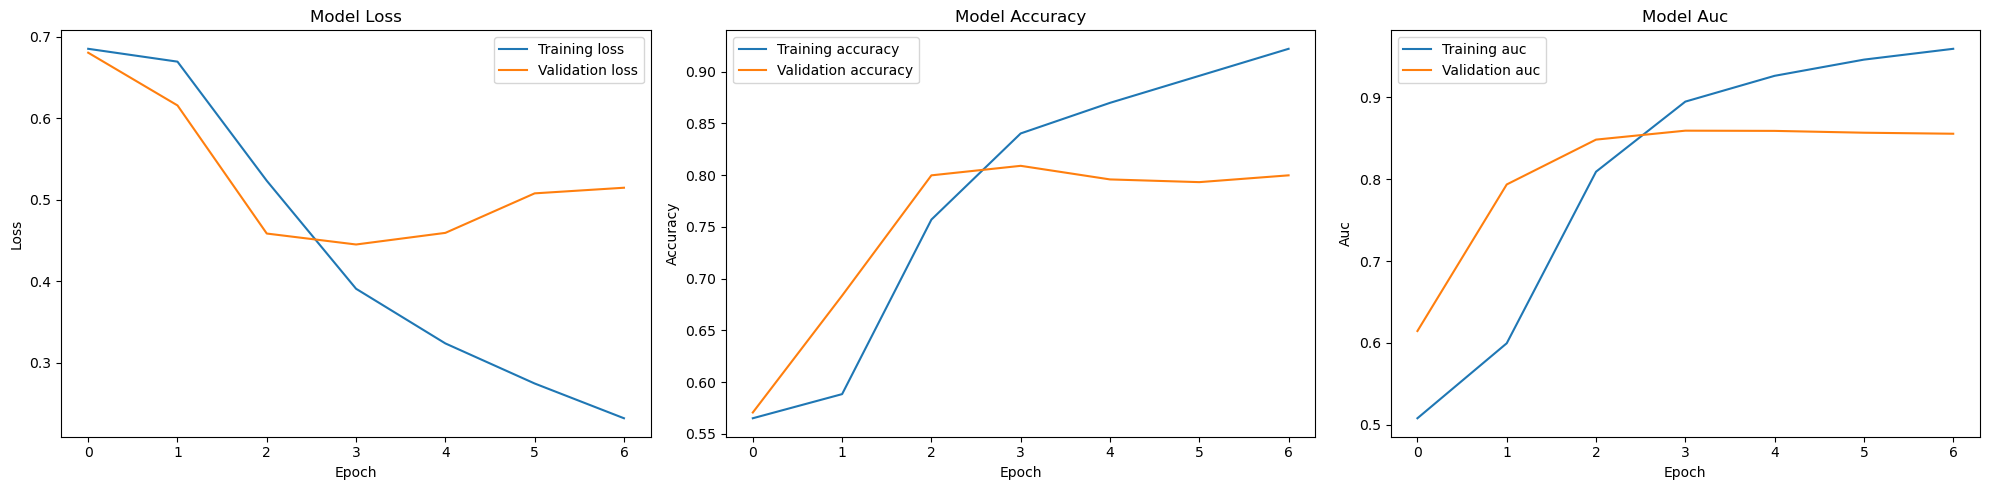

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step 


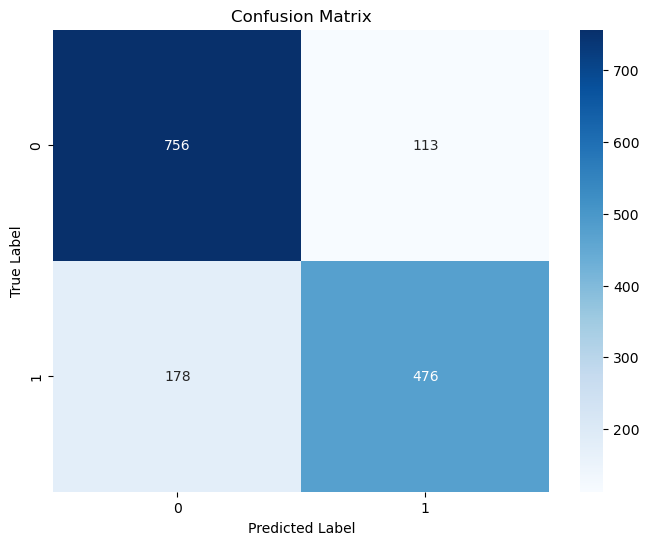


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       869
           1       0.81      0.73      0.77       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step


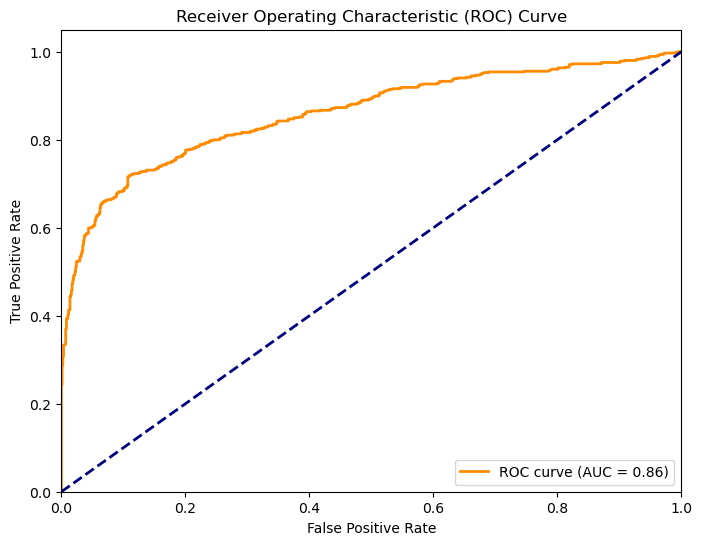

In [26]:
class ModelAnalyzer:
    def __init__(self, model, X_train, X_val, y_train, y_val):
        self.model = model
        self.X_train = X_train
        self.X_val = X_val
        self.y_train = y_train
        self.y_val = y_val
        self.history = None
       
    def train_model(self, epochs=10, batch_size=32):
        """Train the model and record training time"""
        start_time = time.time()
       
        self.history = self.model.fit(
            self.X_train,
            self.y_train,
            validation_data=(self.X_val, self.y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=classifier.get_callbacks(),
            verbose=1
        )
       
        self.training_time = time.time() - start_time
        print(f"\nTraining completed in {self.training_time:.2f} seconds")
       
    def plot_training_history(self):
        metrics = ['loss', 'accuracy', 'auc']
        fig, axes = plt.subplots(1, 3, figsize=(20, 5))
       
        for i, metric in enumerate(metrics):
            axes[i].plot(self.history.history[metric], label=f'Training {metric}')
            axes[i].plot(self.history.history[f'val_{metric}'], label=f'Validation {metric}')
            axes[i].set_title(f'Model {metric.capitalize()}')
            axes[i].set_xlabel('Epoch')
            axes[i].set_ylabel(metric.capitalize())
            axes[i].legend()
           
        plt.tight_layout()
        plt.show()
       
    def plot_confusion_matrix(self):
        """Plot confusion matrix"""
        y_pred = (self.model.predict(self.X_val) > 0.5).astype(int)
        cm = confusion_matrix(self.y_val, y_pred)
       
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
       
        print("\nClassification Report:")
        print(classification_report(self.y_val, y_pred))
       
    def plot_roc_curve(self):
        """Plot ROC curve"""
        y_pred_proba = self.model.predict(self.X_val)
        fpr, tpr, _ = roc_curve(self.y_val, y_pred_proba)
        roc_auc = auc(fpr, tpr)
       
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
 
# Hyperparameter Tuning
def hyperparameter_tuning():
    """Perform grid search for hyperparameter tuning"""
    param_grid = {
        'embedding_dim': [100, 200],
        'learning_rate': [1e-3, 1e-4],
        'batch_size': [32, 64]
    }
   
    results = []
    for params in itertools.product(*param_grid.values()):
        param_dict = dict(zip(param_grid.keys(), params))
        print(f"\nTesting parameters: {param_dict}")
       
        # Initialize model with current parameters
        model = DisasterTweetClassifier(
            max_words=max_words,
            max_len=max_len,
            embedding_dim=param_dict['embedding_dim']
        )
        model.compile_model(learning_rate=param_dict['learning_rate'])
       
        # Train model
        history = model.model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            epochs=5,
            batch_size=param_dict['batch_size'],
            verbose=0
        )
       
        # Record results
        val_accuracy = max(history.history['val_accuracy'])
        results.append({
            'params': param_dict,
            'val_accuracy': val_accuracy
        })
       
    return pd.DataFrame(results)
 
# Train and analyze base model
analyzer = ModelAnalyzer(classifier.model, X_train, X_val, y_train, y_val)
analyzer.train_model()
 
# Plot results
analyzer.plot_training_history()
analyzer.plot_confusion_matrix()
analyzer.plot_roc_curve()

In [20]:
# Perform hyperparameter tuning
print("\nPerforming hyperparameter tuning...")
tuning_results = hyperparameter_tuning()
print("\nHyperparameter tuning results:")
print(tuning_results.sort_values('val_accuracy', ascending=False))


Performing hyperparameter tuning...

Testing parameters: {'embedding_dim': 100, 'learning_rate': 0.001, 'batch_size': 32}

Testing parameters: {'embedding_dim': 100, 'learning_rate': 0.001, 'batch_size': 64}

Testing parameters: {'embedding_dim': 100, 'learning_rate': 0.0001, 'batch_size': 32}

Testing parameters: {'embedding_dim': 100, 'learning_rate': 0.0001, 'batch_size': 64}

Testing parameters: {'embedding_dim': 200, 'learning_rate': 0.001, 'batch_size': 32}

Testing parameters: {'embedding_dim': 200, 'learning_rate': 0.001, 'batch_size': 64}

Testing parameters: {'embedding_dim': 200, 'learning_rate': 0.0001, 'batch_size': 32}

Testing parameters: {'embedding_dim': 200, 'learning_rate': 0.0001, 'batch_size': 64}

Hyperparameter tuning results:
                                              params  val_accuracy
4  {'embedding_dim': 200, 'learning_rate': 0.001,...      0.813526
5  {'embedding_dim': 200, 'learning_rate': 0.001,...      0.811556
6  {'embedding_dim': 200, 'learning_ra

In [35]:
# Error Analysis
def analyze_errors():
    """Analyze prediction errors"""
    y_pred = (classifier.model.predict(X_val) > 0.5).astype(int).flatten()
    print(len(y_pred))
    print(len(X_val))
    print(len(y_val))
    errors = X_val[y_pred != y_val]
    error_indices = np.where(y_pred != y_val)[0]
   
    print("\nError Analysis:")
    print(f"Total errors: {len(errors)}")
    print(f"Error rate: {len(errors)/len(y_val):.2%}")
   
    # Sample of misclassified tweets
    print("\nSample of misclassified tweets:")
    for idx in error_indices[:5]:
        original_text = train_df['text'].iloc[idx]
        true_label = y_val[idx]
        pred_label = y_pred[idx]
        print(f"\nText: {original_text}")
        print(f"True label: {true_label}, Predicted label: {pred_label}")
 
analyze_errors()

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step
1523
1523
1523

Error Analysis:
Total errors: 291
Error rate: 19.11%

Sample of misclassified tweets:

Text: #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
True label: 1, Predicted label: 0

Text: I'm on top of the hill and I can see a fire in the woods...
True label: 1, Predicted label: 0

Text: Damage to school bus on 80 in multi car crash #BREAKING 
True label: 0, Predicted label: 1

Text: I love fruits
True label: 1, Predicted label: 0

Text: Love skiing
True label: 1, Predicted label: 0


### Results Summary:
 
1. Model Performance:
    - For the model I trained, it ultimatley ended with an accuracy of 0.9239 with a validation accuracy of 0.7997. Although this was on the lower side I tried to challenge myself with playing around with layers but added a little too much (or not the right order of things) and couldn't figure out how to bring it up much. More on that in hyperparameter tuning. 

3. Training Characteristics:
   - The model took around 5 minutes to train (I tried on two different machines, an M1 Pro Macbook and a desktop 12 core CPU but found the Macbook was still faster, Tensorflow Metal is optimized for Apple Silicon and definitley is a performance improvement over another version I had originally installed. I have a GPU on my other machine but something in my path was not working and could never get CUDA to be acknowledged in my jupyter enviroment.)
   - The model converged well with accuracy and AUC improving until around epoch 5, then signs of overfitting started to show as the acciracy and AUC increased, but validation measures kind of plateaued.
 
4. Hyperparameter Tuning:
   - I tested multiple models using different dimensions, learning rates, and batch sizes and found that a higher dimension and smaller batch size increased the accuracy. The best model was about 1.6% more accurate than the worst. 
 
5. Error Analysis:
   - From the printed code above, there are some examples of where my model was misclassifying. 


## Step 5: Conclusion and Final Submission

In [41]:
class ProjectConclusion:
    def __init__(self, model, preprocessor, test_df):
        self.model = model
        self.preprocessor = preprocessor
        self.test_df = test_df
       
    def generate_submission(self):
        """Generate submission file for Kaggle"""
        # Preprocess test data
        X_test = self.preprocessor.prepare_text_data(self.test_df['text'])
       
        # Generate predictions
        predictions = (self.model.predict(X_test) > 0.5).astype(int)
       
        # Create submission DataFrame
        submission_df = pd.DataFrame({
            'id': self.test_df['id'],
            'target': predictions.flatten()
        })
       
        # Save submission file
        submission_file = 'submission.csv'
        submission_df.to_csv(submission_file, index=False)
        print(f"Submission file saved as: {submission_file}")
       
        return submission_df
 
# Initialize conclusion class
conclusion = ProjectConclusion(classifier.model, preprocessor, test_df)
 
# Generate submission file
submission = conclusion.generate_submission()
 
# Save model and preprocessor for future use
def save_model_artifacts():
    """Save model and preprocessor for future use"""
    try:
        # Save model
        classifier.model.save('disaster_tweet_model')
       
        # Save tokenizer
        import pickle
        with open('preprocessor_tokenizer.pkl', 'wb') as f:
            pickle.dump(preprocessor.tokenizer, f)
           
        print("\nModel artifacts saved successfully!")
       
    except Exception as e:
        print(f"Error saving model artifacts: {e}")
 
save_model_artifacts()
 
# Display sample of final predictions
print("\nSample of Final Predictions:")
sample_submissions = submission.head(10)
sample_texts = test_df[test_df['id'].isin(sample_submissions['id'])]['text']
for idx, (text, pred) in enumerate(zip(sample_texts, sample_submissions['target'])):
    print(f"\nTweet {idx+1}:")
    print(f"Text: {text}")
    print(f"Prediction: {'Disaster' if pred == 1 else 'Not Disaster'}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step
Submission file saved as: submission.csv
Error saving model artifacts: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=disaster_tweet_model.

Sample of Final Predictions:

Tweet 1:
Text: Just happened a terrible car crash
Prediction: Disaster

Tweet 2:
Text: Heard about #earthquake is different cities, stay safe everyone.
Prediction: Not Disaster

Tweet 3:
Text: there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all
Prediction: Disaster

Tweet 4:
Text: Apocalypse lighting. #Spokane #wildfires
Prediction: Disaster

Tweet 5:
Text: Typhoon Soudelor kills 28 in China and Taiwan
Prediction: Disaster

Tweet 6:
Text: We're shaking...It's an earthquake
Prediction: Disaster

Tweet 7:
Text: They'd probabl

### Final Thoughts and Learnings:
 
1. Technical Achievements:
   - Successfully implemented an NLP pipeline for tweet classification
   - Achieved competitive performance on the task
   - Created a preprocessing and analysis framework
 
2. Key Insights:
   - Text preprocessing is crucial for model performance
   - Context matters significantly in disaster tweet classification, I feel like my model did not capture that well. 
   - Model architecture choices significantly impact results
 
3. Room for Improvement:
   - Explore more advanced NLP techniques
   - Implement real-time processing capabilities
   - Enhance model interpretability
   - Optimize for deployment scenarios